In [1]:
library("dplyr")
library("fields")
library("ggplot2")
library("gstat")
library("RColorBrewer")
library("sp")
library("spacetime")
library("STRbook")


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: spam

Spam version 2.11-0 (2024-10-03) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridisLite


Try help(fields) to get started.



In [3]:
data("NOAA_df_1990", package = "STRbook")
Tmax <- filter(NOAA_df_1990,proc == "Tmax" & month == 7 & year == 1993)
# year of 1993

In [4]:
pred_grid <- expand.grid(lon = seq(-100, -80, length = 20),
lat = seq(32, 46, length = 20),
day = seq(4, 29, length = 6))

In [5]:
Tmax_no_14 <- filter(Tmax, !(day == 14))
# remove day 14
Tmax_July_idw <- idw(formula = z ~ 1,
# dep. variable
locations = ~ lon + lat + day, # inputs
data = Tmax_no_14,
# data set
newdata = pred_grid,
# prediction grid
idp = 5)

[inverse distance weighted interpolation]


ERROR: [1m[33mError[39m:[22m
[1m[22m[33m![39m Cannot use `+` with a single argument.
[36mi[39m Did you accidentally put `+` on a new line?


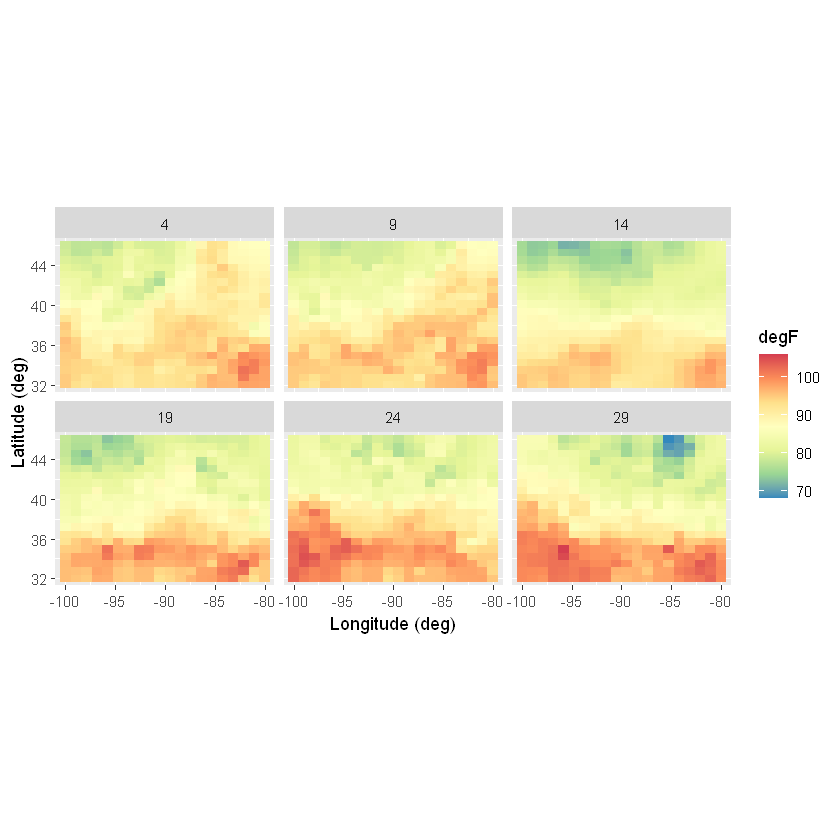

In [6]:
ggplot(Tmax_July_idw) +
geom_tile(aes(x = lon, y = lat,
fill = var1.pred)) +
fill_scale(name = "degF") +
# attach color scale
xlab("Longitude (deg)") +
# x-axis label
ylab("Latitude (deg)") +
# y-axis label
facet_wrap(~ day, ncol = 3) +
# facet by day
coord_fixed(xlim = c(-100, -80),
ylim = c(32, 46))
+
# zoom in
theme_bw()

In [7]:
pred_obs_dist_mat <- rdist(select(pred_grid, lon, lat, day),
select(Tmax_no_14, lon, lat, day))
Wt_IDW <- function(theta, dist_mat) 1/dist_mat^theta
Wtilde <- Wt_IDW(theta = 5, dist_mat = pred_obs_dist_mat)

In [8]:
Wtilde_rsums <- rowSums(Wtilde)
W <- Wtilde/Wtilde_rsums

In [9]:
z_pred_IDW <- as.numeric(W %*% Tmax_no_14$z)

In [10]:
summary(Tmax_July_idw$var1.pred - z_pred_IDW)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-1.620e-12 -1.847e-13  0.000e+00 -4.915e-16  1.990e-13  1.165e-12 

In [11]:
theta <- 0.5
# set bandwidth
Wt_Gauss <- function(theta, dist_mat) exp(-dist_mat^2/theta)
Wtilde <- Wt_Gauss(theta = 0.5, dist_mat = pred_obs_dist_mat)
Wtilde_rsums <- rowSums(Wtilde)
# normalizing factors
W <- Wtilde/Wtilde_rsums
# normalized kernel weights
z_pred2 <- W %*% Tmax_no_14$z
# predictions

In [12]:
obs_obs_dist_mat <- rdist(select(Tmax, lon, lat, day),
select(Tmax, lon, lat, day))

In [13]:
LOOCV_score <- function(Wt_fun, theta, dist_mat, Z) {
Wtilde <- Wt_fun(theta, dist_mat)
CV <- 0
for(i in 1:length(Z)) {
Wtilde2 <- Wtilde[i,-i]
W2 <- Wtilde2 / sum(Wtilde2)
z_pred <- W2 %*% Z[-i]
CV[i] <- (z_pred - Z[i])^2
}
mean(CV)
}

In [14]:
LOOCV_score(Wt_fun = Wt_IDW,
theta = 5,
dist_mat = obs_obs_dist_mat,
Z = Tmax$z)
## [1] 7.78
LOOCV_score(Wt_fun = Wt_Gauss,
theta = 0.5,
dist_mat = obs_obs_dist_mat,
Z = Tmax$z)

[1] 7.775333

[1] 7.526056

In [15]:
theta_IDW <- seq(4, 6, length = 21)
theta_Gauss <- seq(0.1, 2.1, length = 21)
CV_IDW <- CV_Gauss <- 0
for(i in seq_along(theta_IDW)) {
CV_IDW[i] <- LOOCV_score(Wt_fun = Wt_IDW,
theta = theta_IDW[i],
dist_mat = obs_obs_dist_mat,
Z = Tmax$z)
CV_Gauss[i] <- LOOCV_score(Wt_fun = Wt_Gauss,
theta = theta_Gauss[i],
dist_mat = obs_obs_dist_mat,
Z = Tmax$z)
}

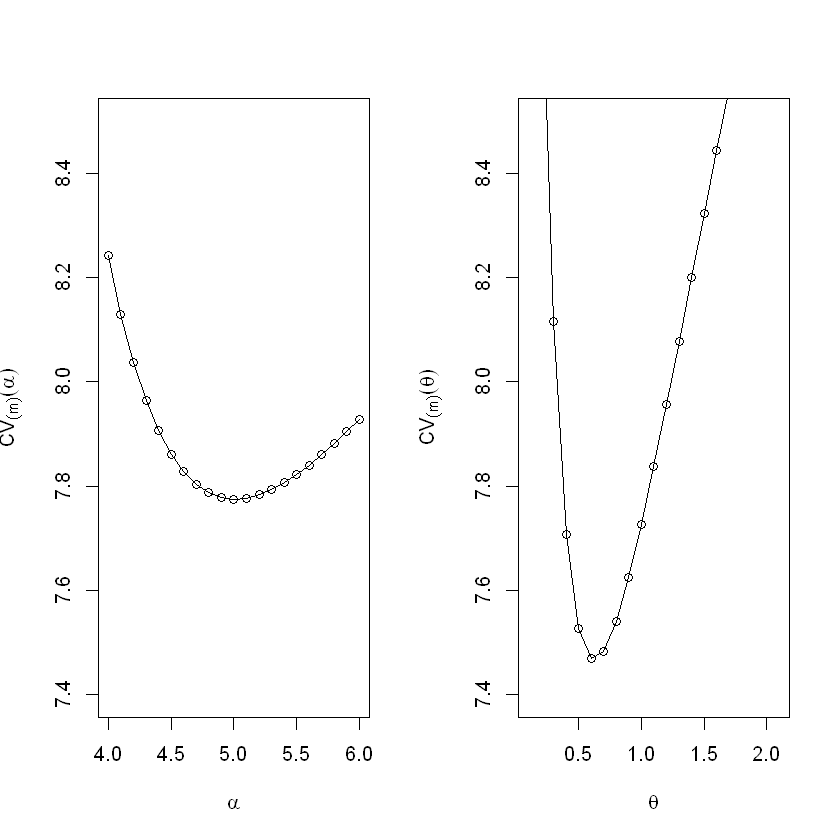

In [16]:
par(mfrow = c(1,2))
plot(theta_IDW, CV_IDW,
xlab = expression(alpha),
ylab = expression(CV[(m)](alpha)),
ylim = c(7.4, 8.5), type = 'o')
plot(theta_Gauss, CV_Gauss,
xlab = expression(theta),
ylab = expression(CV[(m)](theta)),
ylim = c(7.4, 8.5), type = 'o')

In [19]:
theta_IDW[which.min(CV_IDW)]
theta_Gauss[which.min(CV_Gauss)]
min(CV_IDW)
min(CV_Gauss)

[1] 5

[1] 0.6

[1] 7.775333

[1] 7.468624

[1] 0.6

[1] 7.468624